# 含有单个连续型解释变量的模型

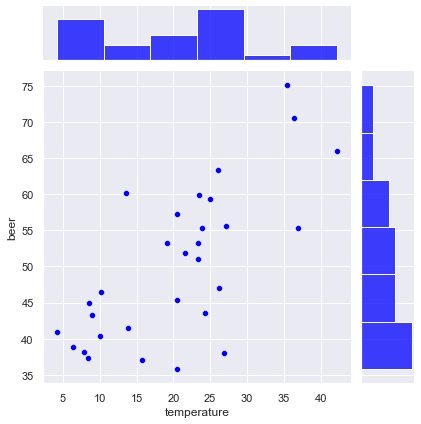

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
# 用于绘图的库
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
# 用于统计模型的库，部分版本会报错
import statsmodels.formula.api as smf
import statsmodels.api as sm
# 设置浮点数打印精度
%precision 3
# 在Jupter Notebook中显示图形
%matplotlib inline
beer = pd.read_csv("./data/5-1-1-beer.csv")
beer.head()
sns.jointplot(x = "temperature", y = "beer",
              data = beer, color = "blue")

## 建模
啤酒销售额 ~ N(β₀ + β₁ X 气温, σ²)
建立一般的正态模型


In [2]:
# 使用statsmodels实现模型化
# 注意这个~符号
in_model = smf.ols(formula = "beer ~ temperature",data = beer).fit()

in_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     28.45
Date:                Mon, 27 Dec 2021   Prob (F-statistic):           1.11e-05
Time:                        16:52:02   Log-Likelihood:                -102.45
No. Observations:                  30   AIC:                             208.9
Df Residuals:                      28   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.6102      3.235     10.699      0.000      27.984      41.237
temperature     0.7654      0.144      5.334      0.000       0.471       1.059
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.290
Skew:                          -0.240   Prob(JB):                        0.865
Kurtosis:                       2.951   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 使用AIC进行模型选择
ols(最小二乘法)

In [3]:
null_model = smf.ols("beer ~ 1", data = beer).fit()
null_model.aic
in_model.aic

# 含有解释变量的模型的AIC更小
in_model.llf

# 解释变量个数
in_model.df_model

# 最终的AIC计算如下:
-2 * (in_model.llf - (in_model.df_model + 1))



208.90902935575437

### 回归直线
模型预测的响应变脸的图形就是回归直线


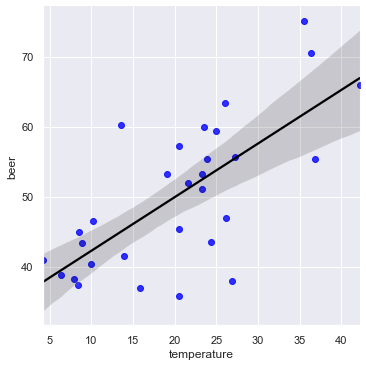

In [4]:
sns.lmplot(x = "temperature", y = "beer", data = beer, scatter_kws = {"color":"blue"},
                line_kws = {"color":"black"})


### 使用模型进行预测


In [12]:
in_model.predict()
in_model.predict(pd.DataFrame({"temperature":[0]}))

# 参数
in_model.params
# 气温20摄氏度的期望
in_model.predict(pd.DataFrame({"temperature":[20]}))

beta0 = in_model.params[0]
beta1 = in_model.params[1]

temperature = 20
beta0 + beta1 + temperature


55.375642843501936

### 获取残差

In [18]:
resid = in_model.resid
print(resid.head(3))

y_hat = beta0 + beta1 * beer["temperature"]
y_hat.head(3)
print((beer.beer - y_hat).head(3))

0   -5.001481
1    5.554095
2   -1.864491
dtype: float64
0   -5.001481
1    5.554095
2   -1.864491
dtype: float64


### 决定系数

In [31]:
mu = np.mean(beer.beer)
y = beer.beer
yhat = in_model.predict()

(np.sum(yhat - mu) ** 2 ) / np.sum((y - mu) ** 2)
# 也可以通过下面语句
in_model.rsquared

# 首先，计算模型可以预测差异与模型不可预测都残差平方和的总和
temp = np.sum((yhat - mu)**2) + sum(resid**2)
temp
np.sum((y - mu)**2)

1 - np.sum(resid**2) / np.sum((y - mu)**2)

0.5039593230611858

### 修正系数

In [33]:
# 通过自由度来考虑决定系数
n = len(beer.beer)
s = 1
1 - ((np.sum(resid**2) / (n - s - 1)) /
     (np.sum((y - mu)**2) / (n - 1)))

# 也可以通过下面的语句
in_model.rsquared_adj

0.48624358459908534

C:\Users\Cherry\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


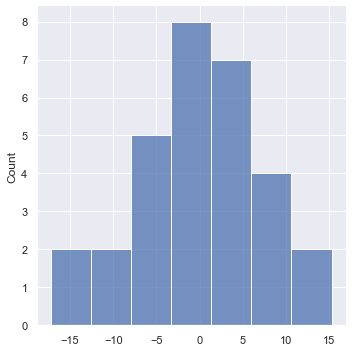

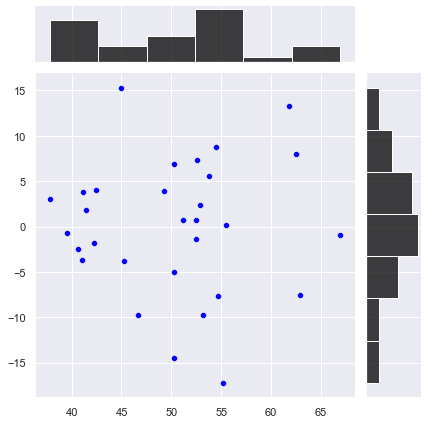

In [38]:
sns.displot(resid)

sns.jointplot(in_model.fittedvalues, resid,
              joint_kws={"color":"blue"},
              marginal_kws={"color":"black"})